# Covid 19 US cases analysis


In this notebook, we will present the steps and results that are used to analyze COVIS 19 cases
data set from New York Times. This dataset is updated daily on github and therefore
represent an accurate number of confirmed cases in US counties over time.
<br>
## Data preliminary analysis
First we would like to introduce the dataset, which can be obtained from https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv.
<br>

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering

In [7]:
total_live_data = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
liveData = pd.read_csv(total_live_data,  dtype={"fips": str})
liveData.head(5)

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0.0
3,2020-01-24,Cook,Illinois,17031,1,0.0
4,2020-01-24,Snohomish,Washington,53061,1,0.0


In [23]:
print(f'Number of rows are {len(liveData)}')
print(f'Number of counties are {len(liveData.county.unique())}')
print(f'Number of distinct dates are {len(liveData.date.unique())}')
print(f'Number of distinct fips are {len(liveData.fips.unique())}')

Number of rows are 1193105
Number of counties are 1930
Number of distinct dates are 441
Number of distinct fips are 3219


As shown above, the data we are using have 6 columns, with date represent record date, county
is the name of the county that report the case, state is the name of the state that county belong
to, fips represents the Federal Information Processing Standards number that is unique for each
county, cases record the number of confirmed cases and deaths is the number of confirmed dead from
COVID in each county. There are over 1 millions rows of data given, with 1,930 counties reporting
covid cases over the time period of 441 days. Furthermore, we can see that there are over three
thousands fips numbers, which is almost twice as many counties, meaning that each county can
be broken further down into smaller regions represent by fips.
<br>
Because the given data is already sorted by date, we can see that Washing was the first
state reported confirmed case, which is quite interesting. Furthermore, the data is very sparse in
the early stage of the time interval, thus making it quite difficult for clustering because there
are not enough information. Thus, we decided to transform the data into matrix form, with
the rows represent each fips, the column represent the date and the value is number of
confirmed cases for each county at a given day.
<br>
To start this transformation, we first observe that we only need 3 columns, date, fips and cases,
because we can deduce the state and county from any given fips. Also the deaths confirmed number
contains many zero, so we decided to drop that column.

In [50]:
covidData = liveData[['date','fips','cases']]
groupByFips = covidData.set_index('date').groupby('fips')

In [57]:
groupByFips.cases.mean().describe()

count      3218.000000
mean       3301.608556
std       11661.757076
min           1.000000
25%         364.626488
50%         849.440001
75%        2165.895579
max      382041.490826
Name: cases, dtype: float64

After grouping the data by fips number, we calculate the means value of cases reported and call
the describe method to find some statistics. Looking the count of 3218 which equals to the number
of fips we find above and confirm that the group by is correct.
<br>
Looking at the mean and standard deviation value, we can see that the data is more spread out, which
indicate that clustering technique would be useful in this application to identify and group
similar data points. Furthermore, from the distribution information, we can see that there are
abnormally, where some group have mean value of only 1 cases, and some having over three hundred
thousands cases.
<br>


<ipython-input-84-8a09abc1e54b>:5: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


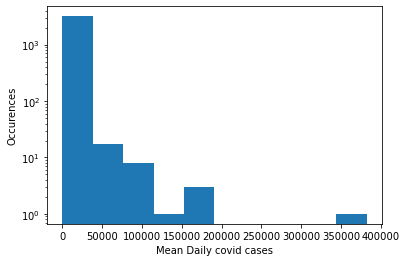

In [84]:
plt.hist(list(groupByFips.cases.mean()))
plt.rcParams['axes.facecolor'] = 'white'
plt.ylabel('Occurences')
plt.xlabel('Mean Daily covid cases')
plt.yscale('log', nonposy='clip')

Using the histogram graph, we can see that the majority of counties have mean COVID-19 cases of less
than 75,000. However, there are regions with significantly more daily cases, and we suspect these regions to be highly
populated, however we will only be confirmed this hypothesis when doing the clustering. Also note that the graph is converted
to log scale for cleaner representation.

## Clustering
In the section, we will discuss our implementation of K-Means and Hierachical Clustering to the presented dataset above.

In [ ]:
fips = list(groupByFips.fips.groups.keys())
resultgroupBy = groupByFips['cases'].apply(list).reset_index(name = 'new')

count      3218.000000
mean       3301.608556
std       11661.757076
min           1.000000
25%         364.626488
50%         849.440001
75%        2165.895579
max      382041.490826
Name: cases, dtype: float64